In [1]:
import qiskit.quantum_info.operators as opTerra
import qiskit.aqua.operators as opAqua
from qiskit.providers.aer.extensions import snapshot_expectation_value
from qiskit import(QuantumCircuit, execute, Aer)
from qiskit import(QuantumRegister, ClassicalRegister)
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import *
from qiskit.circuit import *

import numpy as np
import scipy.optimize as opt
from time import localtime, strftime, time

On reprend ici le code construisant le circuit permettant de générer la superposition des états valides. Il servira à fournir l'état initial :

In [2]:
def buildNextPathCircuit(n):

    """PARAMETRES"""
    N = n * (n - 1) // 2
    nextN = (n + 1) * n // 2

    edgesToVertex = []
    for i in range(n):
        for j in range(0, i):
            edgesToVertex.append((i, j))

    """CREATION CIRCUIT PRINCIPAL"""
    path = QuantumRegister(nextN, name = "x")
    counter = QuantumRegister(n, name = "n")
    controlPath = QuantumRegister(1, name = "a")
    controlSuperposition = QuantumRegister(1, name = "b")

    circuit = QuantumCircuit(path, controlPath,
                             controlSuperposition,
                             counter,
                             name = "circuit " + str(n) + " -> " +
                             str(n + 1))

    circuit.swap(counter[0], counter[-1])

    circuit.barrier()
    circuit.barrier()

    """BOUCLE GENERALE"""
    for e in range(N):
        j, k = edgesToVertex[e]

        #Incrémentation du compteur
        for ii in range(1, n):
            i = n - ii
            circuit.cswap(path[e], counter[i], counter[i - 1])

        circuit.append(CCXGate(ctrl_state = "10"),
                               [controlSuperposition[0],
                               path[e], controlPath[0]])

        circuit.barrier()

        #Boucle qui change l'arête si besoin en controllant et lui applique la bonne superposition en fonction du compteur
        for i in range(0, n):

            gateSupr = RYGate(2 * np.arcsin(1 / np.sqrt(n - i)))

            ctrlGateSupr = gateSupr.control(2, ctrl_state = "11")
            circuit.append(ctrlGateSupr, [controlPath[0],
                           counter[i], path[e]])

        gateNew = CCXGate(ctrl_state = "01")
        circuit.append(gateNew, [controlPath[0], path[e], path[N + j]])

        circuit.append(gateNew, [controlPath[0], path[e], path[N + k]])

        circuit.barrier()

        circuit.append(CCXGate(ctrl_state = "11"), [path[N + j],
                                path[N + k], controlSuperposition[0]])

        circuit.append(C3XGate(ctrl_state = "110"), [path[e],
                                path[N + j], path[N + k],
                                controlPath[0]])

        circuit.append(CCXGate(ctrl_state = "10"),
                                [controlSuperposition[0],
                                path[e],
                                controlPath[0]])

        circuit.barrier()
        circuit.barrier()

    """REINITIALISATION"""
    circuit.x(controlSuperposition[0])
    circuit.swap(counter[0], counter[-1])

    return circuit

In [3]:
def buildCircuitPath(n):
    N = n * (n - 1) // 2

    path = QuantumRegister(N, name = "x")
    counter = QuantumRegister(n - 1, name = "n")
    controlPath = QuantumRegister(1, name  = "a")
    controlSuperposition = QuantumRegister(1, name = "b")

    #cPath = ClassicalRegister(n * (n - 1) // 2, name = "cX")

    circuit = QuantumCircuit(path, controlPath, controlSuperposition,
                             counter, name = "Superposition")

    """INITIALISATION COMPTEUR + CHEMIN POUR 3"""
    circuit.x(path[:3])
    circuit.x(counter[0])

    circuit.barrier()

    """CONSTRUCTIONS SUCCESSIVES"""
    for i in range(3, n):
        Ni = i * (i + 1) // 2

        circuit.append(buildNextPathCircuit(i), path[:Ni] +
                                                controlPath[:] +
                                                controlSuperposition[:] +
                                                counter[:i])
        circuit.barrier()

    #circuit.measure(path, cPath)

    return circuit

Les fonctions suivantes servent à construire la matrice décrivant l'opérateur B_2 à la main, tel qu'exposé en partie 7.3.2 du rapport :

In [1]:
def vertexToEdge(n):
    tab = []
    e = 0
    for i in range(n):
        tab.append([])
        for j in range(0, i):
            tab[i].append(e)
            e += 1
    return tab

def edgesToVertex(n):
    tab = []
    for i in range(n):
        for j in range(0, i):
            tab.append((i, j))
    return tab

def nextPath(l, n):
    if n == 3: return [1, 1, 1]
    prevN = (n - 1) * (n - 2) // 2
    neiN = []
    vte = vertexToEdge(n)
    etv = edgesToVertex(n)

    for i in range(0, n - 1):
        if l[i + prevN] == 1:
            neiN.append(i)

    i, j = neiN
    e0 = vte[j][i]
    l[e0] = 1
    l[i + prevN] = 0
    l[j + prevN] = 0

    e = e0 + 1
    while e < prevN and l[e] == 0:
        e += 1

    if e != (n - 1) * (n - 2) // 2:
        i, j = etv[e]
        l[e] = 0
        l[i + prevN] = 1
        l[j + prevN] = 1

    else:
        l1 = nextPath(l[:prevN], n - 1)

        for i in range(0, prevN):
            l[i] = l1[i]
        e = 0
        while l[e] == 0:
            e += 1
        i, j = etv[e]
        l[e] = 0
        l[i + prevN] = 1
        l[j + prevN] = 1

    return l

def getOnePath(n):
    path = []
    for i in range(1, n):
        for k in range(i - 1):
            path.append(0)
        path.append(1)
    path[(n - 1) * (n - 2) // 2] = 1
    return path

def buildMatrix(n):
    N = n * (n - 1) // 2
    path = getOnePath(n)
    M = np.zeros((2 ** N, 2 ** N))
    nbPath = np.math.factorial(n - 1) // 2

    for i in range(nbPath):
        prevPath = np.copy(path)
        nextPath(path, n)
        k1, k2 = 0, 0
        p2 = 1
        for j in range(N):
            k1 += path[j] * p2
            k2 += prevPath[j] * p2
            p2 *= 2
        M[k1, k2] = 1
        M[k2, k1] = 1

    return M

La fonction suivante crée le circuit du QAOA, l'exécute et renvoie les résultats :

In [4]:
def TspQaoaFaisable2(n, p, w, shots = 1000000, T = 1):

    #INITIALISATION
    N = n * (n - 1) // 2
    w = w / np.gcd.reduce(w)
    path = QuantumRegister(N, name = "x")
    auxPath = QuantumRegister(n + 1, name = "aux0")
    auxCtrl = QuantumRegister(1, name = "aux1")
    numQubits = N + n + 2

    backend = Aer.get_backend("qasm_simulator")

    qaoaCircuit = QuantumCircuit(path, auxPath, auxCtrl, name = "Global Circuit")
    circuitPath = buildCircuitPath(n)
    inverseCircuitPath = circuitPath.inverse()

    initCircuit = QuantumCircuit(numQubits, name = "Init")
    initCircuit.append(circuitPath, range(numQubits - 1))

    qaoaCircuit.append(initCircuit, range(numQubits))
    qaoaCircuit.barrier()

    #CONTRUCTION DES CIRCUITS UCOST ET UDRIVER
    #Ces circuits sont paramÃ©trÃ©s par un paramÃ¨tre t
    t = Parameter("t")

    UCostCircuit = QuantumCircuit(path, name = "UCost")
    for e in range(N):
        UCostCircuit.p(- t / T * w[e], path[e])

    UDriverCircuit = QuantumCircuit(path, auxPath, auxCtrl, name = "UDriver")

    matrixCost = - buildMatrix(n)
    HDriver = opAqua.MatrixOp(matrixCost)
    UDriverOp = (t / T * HDriver).exp_i()
    UDriverCircuit.append(UDriverOp, range(N))

    #CONTRUCTION DU CIRCUIT GLOBAL PARAMETRE
    parBeta = ParameterVector("Beta", p)
    parGamma = ParameterVector("Gamma", p)

    for k in range(p):
        currentUCostCircuit = UCostCircuit.assign_parameters({t: parGamma[k]})
        qaoaCircuit.append(currentUCostCircuit, path)

        currentUDriverCircuit = UDriverCircuit.assign_parameters({t: parBeta[k]})
        qaoaCircuit.append(currentUDriverCircuit, range(numQubits))

        qaoaCircuit.barrier()

    #CONSTRUCTION DE L'OPERATEUR DE COUT
    I = opAqua.I ^ N
    HCost = 0
    for e in range(N):
        Ze = (opAqua.I ^ (N - e - 1)) ^ opAqua.Z ^ (opAqua.I ^ e)
        HCost += w[e] / 2 * (I - Ze)

    HCostTerra = opTerra.Operator(HCost.to_matrix())

    qaoaCircuit.snapshot_expectation_value('Cost', HCostTerra, path)

    #MINIMISATION
    #Fonction Ã  minimiser
    def qaoaCost(parValue):
        listValBeta, listValGamma = parValue[:p], parValue[p:]

        currentCircuit = qaoaCircuit.bind_parameters({parBeta: listValBeta, parGamma: listValGamma})
        results = execute(currentCircuit, backend, shots = 100).result()
        c = results.data()['snapshots']['expectation_value']['Cost'][0]['value'].real
        return c

    initBeta = np.pi * np.random.random(p)
    initGamma = 2 * np.pi * np.random.random(p)
    initX = np.append(initBeta, initGamma)

    resultOpt = opt.minimize(qaoaCost, x0 = initX, options = {'maxiter': 20000, 'disp': False}, bounds = [(0, np.pi)] * p + [(0, 2 * np.pi)] * p)
    c = qaoaCost(resultOpt.x)
    bestPar = resultOpt.x
    listBeta, listGamma = bestPar[:p], bestPar[p:]

    print(c)

    #EXECUTION FINALE
    pathMeas = ClassicalRegister(N, name = "c")
    bestCircuit = qaoaCircuit.bind_parameters({parBeta: listBeta, parGamma: listGamma})
    bestCircuit.add_register(pathMeas)
    bestCircuit.measure(path, pathMeas)
    results = execute(bestCircuit, backend, shots = shots).result()
    return results.get_counts(bestCircuit)

Choix des paramètres (nombre de villes et poids des arêtes) :

In [5]:
n = 5
weight = [1,1,1,1,1,1,1,1,1,1]

result = TspQaoaFaisable2(5, 1, weight)

C:\Users\geode\anaconda3\lib\site-packages\qiskit\aqua\operators\operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


5.000000000000013


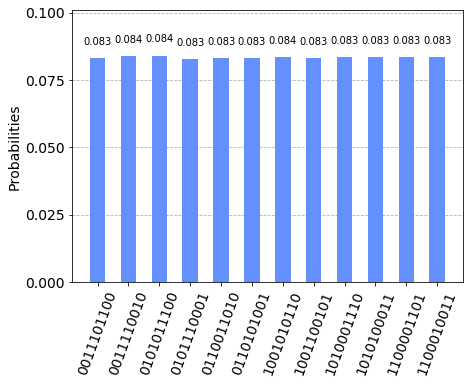

In [6]:
plot_histogram(result)